# Heart Failure PAF Calculations 

This workbook is designed to find the PAF for BMI to heart failure ONLY while NOT considering risk correlation and mediation. The more complex version that includes these considerations is in another workbook. 

In [1]:
from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 60)
import seaborn as sns

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages
import scipy.stats
from typing import List, Tuple, Union
import scipy.stats as sp

In [2]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')

In [3]:
sim = InteractiveContext(Path(path), setup=False)
sim.configuration.update({
                          'population':
                              {'population_size': 10_000,
                              },
                          'time':
                              {'start':
                                  {'year': 2021
                                  }
                              }
                          }
                        )
sim.setup()

2023-02-06 10:33:55.536 | DEBUG    | vivarium.framework.values:register_value_modifier:392 - Registering metrics.1.population_manager.metrics as modifier to metrics
2023-02-06 10:33:55.678 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:66 - Running simulation from artifact located at /ihme/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf.
2023-02-06 10:33:55.680 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:67 - Artifact base filter terms are ['draw == 0'].
2023-02-06 10:33:55.684 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:68 - Artifact additional filter terms are None.
2023-02-06 10:33:56.306 | DEBUG    | vivarium.framework.values:_register_value_producer:338 - Registering value pipeline cause_specific_mortality_rate
2023-02-06 10:33:56.306 | DEBUG    | vivarium.framework.values:_register_value_producer:338 - Registering value pipeline mortality_rate
2023-02-06 10:33:56.918 | DEBUG    | vivarium.framework.values:_regis

In [4]:
pop0 = sim.get_population()
pop0.head()

,tracked,entrance_time,location,exit_time,sex,age,alive,years_of_life_lost,cause_of_death,years_lived_with_disability,...,ldlc_medication,ldlc_medication_adherence,polypill,sbp_multiplier,sbp_medication_adherence,ldlc_multiplier,outreach,sbp_medication,scheduled_date,visit_type
0,True,2020-12-04,Alabama,NaT,Female,47.388882,alive,0.0,not_dead,0.0,...,no_treatment,cat3,cat2,1.0,cat3,1.000,cat2,no_treatment,NaT,none
1,True,2020-12-04,Alabama,NaT,Male,41.564194,alive,0.0,not_dead,0.0,...,no_treatment,cat3,cat2,1.0,cat3,1.000,cat2,no_treatment,NaT,none
2,True,2020-12-04,Alabama,NaT,Female,53.155826,alive,0.0,not_dead,0.0,...,medium_intensity,cat3,cat2,1.0,cat1,1.362,cat2,one_drug_half_dose_efficacy,NaT,none
3,True,2020-12-04,Alabama,NaT,Male,30.457692,alive,0.0,not_dead,0.0,...,no_treatment,cat1,cat2,1.0,cat3,1.000,cat2,no_treatment,NaT,none
4,True,2020-12-04,Alabama,NaT,Female,19.554806,alive,0.0,not_dead,0.0,...,no_treatment,cat1,cat2,1.0,cat3,1.000,cat2,no_treatment,NaT,none


In [5]:
pop1 = pop0[['sex','alive','age']]

In [6]:
#pop0.columns

In [7]:
#sim.list_values()

In [8]:
data1 = pd.concat([pop1,
                   sim.get_value('high_body_mass_index_in_adults.propensity')(pop0.index).rename('bmi_propensity'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('bmi_exposure'),
                  ], axis=1)
data1.head()

,sex,alive,age,bmi_propensity,bmi_exposure
0,Female,alive,47.388882,0.208828,23.564850
1,Male,alive,41.564194,0.358604,25.661107
2,Female,alive,53.155826,0.531571,34.110372
3,Male,alive,30.457692,0.388049,26.473747
4,Female,alive,19.554806,0.672873,5.000000


In [9]:
data1 = data1.loc[(data1.age > 25) & (data1.alive == 'alive')]

In [10]:
age_group = pd.cut(data1.age, bins=[25,30,35,40,45,50,55,60,65,70,75,80,85,90,125],labels=['25_to_30','30_to_35','35_to_40','40_to_45','45_to_50','50_to_55','55_to_60','60_to_65','65_to_70','70_to_75','75_to_80','80_to_85','85_to_90','90_to_125'])
data1.insert(5, 'age_group', age_group)

In [11]:
data1['bmi_exposure_truncated'] = np.nan
for i in range(len(data1)):
    data1['bmi_exposure_truncated'].iloc[i] = min([data1['bmi_exposure'].iloc[i],40.8])
data1

/tmp/ipykernel_1518113/1974891228.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['bmi_exposure_truncated'].iloc[i] = min([data1['bmi_exposure'].iloc[i],40.8])


,sex,alive,age,bmi_propensity,bmi_exposure,age_group,bmi_exposure_truncated
0,Female,alive,47.388882,0.208828,23.564850,45_to_50,23.564850
1,Male,alive,41.564194,0.358604,25.661107,40_to_45,25.661107
2,Female,alive,53.155826,0.531571,34.110372,50_to_55,34.110372
3,Male,alive,30.457692,0.388049,26.473747,30_to_35,26.473747
6,Male,alive,33.645113,0.199137,22.520013,30_to_35,22.520013
...,...,...,...,...,...,...,...
9994,Male,alive,82.973183,0.491704,26.062478,80_to_85,26.062478
9995,Female,alive,31.875800,0.356089,27.354193,30_to_35,27.354193
9996,Male,alive,69.906989,0.013521,19.319172,65_to_70,19.319172
9998,Female,alive,77.277694,0.623941,31.170490,75_to_80,31.170490


## Adding RR and TMREL so I can find the individual RR for a Simulant

Note that while this method will randomly generate data, I eventually need to match the RR's to the simulant for the specific draw. As HF has not been added yet, I am not sure I can do this currently.

Also, we might just have the engineers add this to their initialization tasks instead! 

In [12]:
def get_lognorm_from_quantiles(median: float, lower: float, upper: float,
                               quantiles: Tuple[float, float] = (0.025, 0.975)) -> sp.lognorm:
    mu = np.log(median)
    stdnorm_quantiles = sp.norm.ppf(quantiles)
    norm_quantiles = np.log([lower, upper])
    sigma = (norm_quantiles[1] - norm_quantiles[0]) / (stdnorm_quantiles[1] - stdnorm_quantiles[0])
    return sp.lognorm(s=sigma, scale=median)

In [13]:
test2 = get_lognorm_from_quantiles(1.14,1.12,1.16).rvs(size=len(data1))

In [14]:
data1['RR'] = test2
data1.head()

,sex,alive,age,bmi_propensity,bmi_exposure,age_group,bmi_exposure_truncated,RR
0,Female,alive,47.388882,0.208828,23.564850,45_to_50,23.564850,1.133916
1,Male,alive,41.564194,0.358604,25.661107,40_to_45,25.661107,1.130959
2,Female,alive,53.155826,0.531571,34.110372,50_to_55,34.110372,1.137219
3,Male,alive,30.457692,0.388049,26.473747,30_to_35,26.473747,1.156343
6,Male,alive,33.645113,0.199137,22.520013,30_to_35,22.520013,1.128323


In [15]:
np.random.seed(123)
test3 = np.random.uniform(20,25,len(data1))
test3

array([23.48234593, 21.43069667, 21.13425727, ..., 23.09954019,
       24.65176124, 22.11263259])

In [16]:
data1['TMREL'] = test3
data1.head()

,sex,alive,age,bmi_propensity,bmi_exposure,age_group,bmi_exposure_truncated,RR,TMREL
0,Female,alive,47.388882,0.208828,23.564850,45_to_50,23.564850,1.133916,23.482346
1,Male,alive,41.564194,0.358604,25.661107,40_to_45,25.661107,1.130959,21.430697
2,Female,alive,53.155826,0.531571,34.110372,50_to_55,34.110372,1.137219,21.134257
3,Male,alive,30.457692,0.388049,26.473747,30_to_35,26.473747,1.156343,22.756574
6,Male,alive,33.645113,0.199137,22.520013,30_to_35,22.520013,1.128323,23.597345


## Finding the individual simulant's RR and PAF

In [17]:
data1['sim_RR'] = np.nan
for i in range(len(data1)):
    data1['sim_RR'].iloc[i] = data1['RR'].iloc[i]**[max((data1['bmi_exposure_truncated'].iloc[i] - data1['TMREL'].iloc[i]),0)]
data1

/tmp/ipykernel_1518113/1933464134.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['sim_RR'].iloc[i] = data1['RR'].iloc[i]**[max((data1['bmi_exposure_truncated'].iloc[i] - data1['TMREL'].iloc[i]),0)]


,sex,alive,age,bmi_propensity,bmi_exposure,age_group,bmi_exposure_truncated,RR,TMREL,sim_RR
0,Female,alive,47.388882,0.208828,23.564850,45_to_50,23.564850,1.133916,23.482346,1.010423
1,Male,alive,41.564194,0.358604,25.661107,40_to_45,25.661107,1.130959,21.430697,1.683070
2,Female,alive,53.155826,0.531571,34.110372,50_to_55,34.110372,1.137219,21.134257,5.304420
3,Male,alive,30.457692,0.388049,26.473747,30_to_35,26.473747,1.156343,22.756574,1.715947
6,Male,alive,33.645113,0.199137,22.520013,30_to_35,22.520013,1.128323,23.597345,1.000000
...,...,...,...,...,...,...,...,...,...,...
9994,Male,alive,82.973183,0.491704,26.062478,80_to_85,26.062478,1.135503,22.670537,1.538846
9995,Female,alive,31.875800,0.356089,27.354193,30_to_35,27.354193,1.126426,20.679220,2.213671
9996,Male,alive,69.906989,0.013521,19.319172,65_to_70,19.319172,1.118217,23.099540,1.000000
9998,Female,alive,77.277694,0.623941,31.170490,75_to_80,31.170490,1.146554,24.651761,2.438798


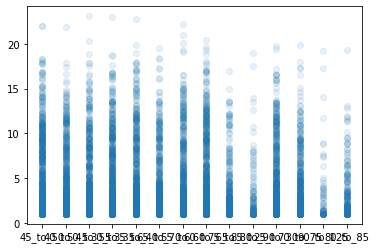

In [18]:
data2 = data1.loc[data1.sim_RR < 6000]
plt.scatter(data2.age_group, data2.sim_RR, alpha=0.1)

(array([2.266e+03, 7.490e+02, 5.320e+02, 4.640e+02, 3.790e+02, 3.120e+02,
        2.470e+02, 2.130e+02, 1.600e+02, 1.560e+02, 1.380e+02, 1.020e+02,
        1.060e+02, 9.800e+01, 1.190e+02, 1.090e+02, 1.180e+02, 1.030e+02,
        1.040e+02, 1.020e+02, 9.300e+01, 7.800e+01, 9.600e+01, 9.000e+01,
        8.700e+01, 6.100e+01, 4.900e+01, 5.000e+01, 4.400e+01, 3.100e+01,
        2.800e+01, 3.000e+01, 1.100e+01, 1.800e+01, 1.300e+01, 2.200e+01,
        1.800e+01, 7.000e+00, 1.300e+01, 5.000e+00, 5.000e+00, 7.000e+00,
        4.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 3.000e+00,
        1.000e+00, 3.000e+00]),
 array([ 1.        ,  1.44127722,  1.88255443,  2.32383165,  2.76510887,
         3.20638609,  3.6476633 ,  4.08894052,  4.53021774,  4.97149495,
         5.41277217,  5.85404939,  6.29532661,  6.73660382,  7.17788104,
         7.61915826,  8.06043547,  8.50171269,  8.94298991,  9.38426713,
         9.82554434, 10.26682156, 10.70809878, 11.149376  , 11.59065321,
        12.

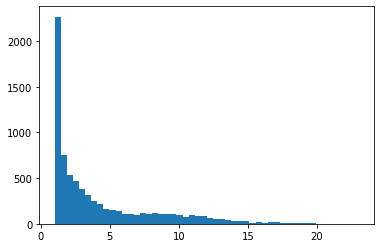

In [19]:
plt.hist(data2.sim_RR, bins = 50)

In [20]:
data_grouped = data1.groupby(['sex', 'age_group']).sim_RR.describe().filter(['mean','std']).reset_index()
data_grouped

,sex,age_group,mean,std
0,Female,25_to_30,4.290312,3.934106
1,Female,30_to_35,5.108077,4.241910
2,Female,35_to_40,4.331428,4.046023
3,Female,40_to_45,4.056204,3.707285
4,Female,45_to_50,4.574022,4.027391
5,Female,50_to_55,4.486463,4.026555
6,Female,55_to_60,4.380628,4.123239
7,Female,60_to_65,5.162076,4.334473
8,Female,65_to_70,4.134571,3.809676
9,Female,70_to_75,4.731612,4.028149


In [33]:
data_grouped2 = data1.groupby(['sex', 'age_group'], as_index=False).mean()
data_grouped2['PAF'] = (data_grouped2['sim_RR'] - 1) / data_grouped2['sim_RR']
data_grouped2

,sex,age_group,age,bmi_propensity,bmi_exposure,bmi_exposure_truncated,RR,TMREL,sim_RR,PAF
0,Female,25_to_30,27.524968,0.496819,30.964830,29.864194,1.140330,22.502696,4.290312,0.766917
1,Female,30_to_35,32.320013,0.529948,33.170805,31.604550,1.140496,22.530328,5.108077,0.804232
2,Female,35_to_40,37.568942,0.525717,31.216305,30.277913,1.139816,22.413765,4.331428,0.769129
3,Female,40_to_45,42.542961,0.505146,30.647594,29.707105,1.139887,22.466482,4.056204,0.753464
4,Female,45_to_50,47.369076,0.500788,31.814019,30.538748,1.140815,22.610521,4.574022,0.781374
5,Female,50_to_55,52.503612,0.498852,31.294312,30.403067,1.140184,22.414429,4.486463,0.777107
6,Female,55_to_60,57.588265,0.485547,31.579655,29.979386,1.140094,22.496061,4.380628,0.771722
7,Female,60_to_65,62.442279,0.502187,33.088281,31.414041,1.139656,22.371243,5.162076,0.806279
8,Female,65_to_70,67.407831,0.504204,30.820834,29.673045,1.139896,22.647597,4.134571,0.758137
9,Female,70_to_75,72.435931,0.544055,32.437449,31.024044,1.139982,22.596889,4.731612,0.788656


This is better with a maximum set and using the median, but it is still quite high. I think if we find improved BMI data that would certainly help with the situation, but I also think it is just a high RR value. 

It could also be in part since this is a literature value and not a GBD one, so might be less calibrated. 